In [1]:
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import numpy as np
import matplotlib.pyplot as plt
import jax_unirep
import haiku as hk
import jax
import jax.numpy as jnp
import functools
from sklearn.decomposition import PCA

In [2]:
import jax.scipy.stats.norm as norm
norm.cdf(-18, loc=-18)

DeviceArray(0.5, dtype=float32)

In [2]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')
print(blosum92)

[[ 4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0 -2 -1  0 -4]
 [-1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3 -1  0 -1 -4]
 [-2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  3  0 -1 -4]
 [-2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  4  1 -1 -4]
 [ 0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1 -3 -3 -2 -4]
 [-1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0  3 -1 -4]
 [-1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  1  4 -1 -4]
 [ 0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3 -1 -2 -1 -4]
 [-2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0  0 -1 -4]
 [-1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3 -3 -3 -1 -4]
 [-1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1 -4 -3 -1 -4]
 [-1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0  1 -1 -4]
 [-1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1 -3 -1 -1 -4]
 [-2 -3 -3 -3 -2 -3 -3 -3

In [3]:
def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += blosum92[idx1][idx2]
    return jax.nn.sigmoid(score/len(seqlist1))

In [24]:
def hamming(seq1, seq2): # seq1 and seq2 are of same length
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    hamming_distance = 0.
    for i in range(len(seqlist1)):
        if seqlist1[i] == seqlist2[i]:
            continue
        hamming_distance += 1.
    return 1 - hamming_distance / len(seqlist1)

In [4]:
#target_seq = 'GIGAVLKVLTTGLPALISWIKRKRQQ'
target_seq = 'GIGAVLKVLT'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)
#print(target_rep.shape)
'''
seqs = ['GIGAVLKVLKAGLPALIVTLKRKIVQ',
       'PPGATLKKHTTGSVALISWIWARIQQ',
       'GIGAVLKVLTTGLKTLISAAKRKRAA',
       'HAPPVLKVLTTGLAPPLVWIKRKRTH',
       'GIGAVLUIHKLSSVAAWRPPKRKRQQ',
       'PTWIIFLKAQWEQHSNLTNMRTFPEV',
        'TISHFVCNHDICAWIKDMQAMQIKMC',
        'CESWLWKRLFDGHADRWRSMPDYPIW',
        'YLVENPLMFPLVAAFIHQWTRQISWH',
        'QTEERLEAQISIYYIGAWSHYKVTDE']
'''

seqs = ['GIGAVLKVLK',
       'PPGATLKKHT',
       'LTGAVLKVLK',
       'HAPPVLKVLT',
       'AWRPPKRKRQ',
       'PTWIIFLKAQ',
       'TISHFVCNHD',
       'CESWLWKRLF',
       'YLVENPLMFP',
       'QTEERLEAQI',
       'GFGARLKVPT',
       'VIRAVQKVLT']
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
print(labels)

[0.98201376 0.8021839  0.9241418  0.8807971  0.21416503 0.2890505
 0.26894143 0.35434368 0.21416503 0.3318122  0.94267577 0.9088771 ]


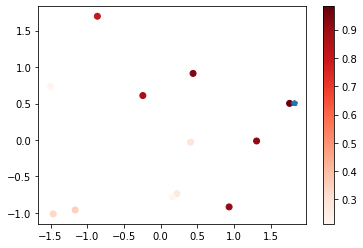

In [5]:
pca = PCA(n_components=2)
pca.fit(reps)
proj_x = pca.transform(reps)
plt.scatter(proj_x[:,0], proj_x[:,1], c=labels, cmap=plt.get_cmap('Reds'))
plt.colorbar()
proj_l = pca.transform(target_rep)
plt.plot(proj_l[:,0], proj_l[:,1], 'p')

In [6]:
key = jax.random.PRNGKey(0)
c = alpdesign.EnsembleBlockConfig()
forward_fxn, full_forward_fxn = alpdesign.build_model(c)
full_forward_t = hk.without_apply_rng(hk.transform(full_forward_fxn))

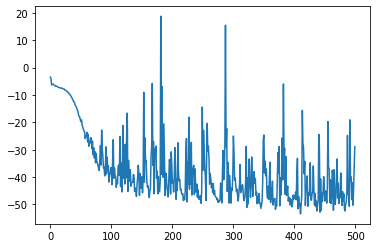

In [7]:
params, losses = alpdesign.ensemble_train(
    key, full_forward_t, c, reps, labels, epochs=500, learning_rate=1e-3)
forward_t = hk.without_apply_rng(hk.transform(forward_fxn))
forward = functools.partial(forward_t.apply, params)
plt.plot(losses)

In [8]:
# e2e is a haiku func
def e2e(logits): # params is trained mlp params
    s = alpdesign.SeqpropBlock()(logits)
    us = alpdesign.seq2useq(s)
    u = alpdesign.differentiable_jax_unirep(us)
    return forward(u)
e2e_t = hk.transform(e2e)
init_logits = jax.random.normal(key, shape=((10, 20)))
e2e_params = e2e_t.init(key, init_logits)

def e2e_fxn(x, key):
    e2e_params, logits = x
    yhat = e2e_t.apply(e2e_params, key, logits)
    return yhat

(13, 1900)
['G', 'G', 'G', 'G', 'G', 'G', 'L', 'P', 'A', 'A'] 0.40131235


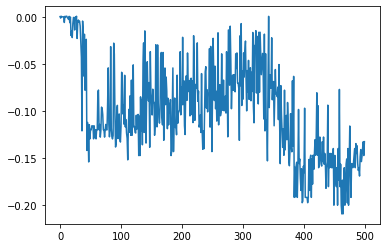

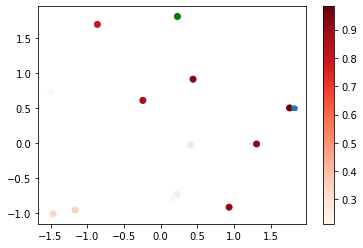

(14, 1900)
['T', 'E', 'K', 'R', 'P', 'H', 'Y', 'S', 'N', 'C'] 0.10909683


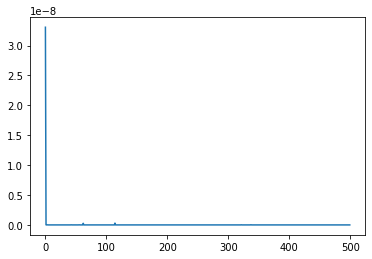

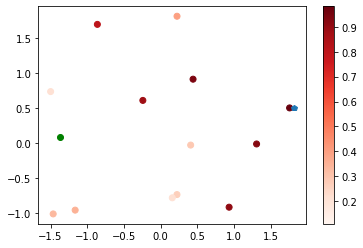

In [ ]:
batch_size = 5
for i in range(10):
    key, tkey = jax.random.split(key, num=2)
    init_x = 0.1*jax.random.normal(key, shape=(10, 20))
    x, loss_curve = alpdesign.bayes_opt(key, e2e_fxn, labels, (e2e_t.init(tkey, init_logits), init_x), iter_num=500, learning_rate=1e-1, epsilon=0.01)
    plt.plot(loss_curve)
    #break
    params, losses = alpdesign.ensemble_train(
        tkey, full_forward_t, c, reps, labels, epochs=500, learning_rate=1e-3)    
    forward_t = hk.without_apply_rng(hk.transform(forward_fxn))
    forward = functools.partial(forward_t.apply, params)
    rb = x[0]
    logits = x[1]
    #print(logits)
    key, tkey = jax.random.split(key, num=2)
    vec = alpdesign.seq.forward_seqprop.apply(rb, key, logits)
    s = decode_seq(vec)
    reps = np.concatenate((reps, get_reps([s])[0]))
    y = blosum(target_seq, s)
    print(reps.shape)
    print(s, y)
    labels = np.concatenate((labels, np.array(y).reshape(1,)))
    
    plt.figure()
    proj_x = pca.transform(reps)
    #print(proj_x)
    plt.scatter(proj_x[:,0], proj_x[:,1], c=labels, cmap=plt.get_cmap('Reds'))
    plt.colorbar()
    proj_l = pca.transform(target_rep)
    plt.plot(proj_l[:,0], proj_l[:,1], 'p')
    plt.plot(proj_x[-1, 0], proj_x[-1, 1], 'o', color='green')    
    plt.show()
    

In [ ]:
['GIGAVLKILIAAARPREAITAALKKR']
['GIGAVLKVLTTGLPALISWIKRKRQQ']